# 4. Spatial interpolation of global temperature field using manifold GPs

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import tensorflow_probability
tfp = tensorflow_probability.experimental.substrates.jax
tfk = tfp.math.psd_kernels

import os
path_to_tex = '/Library/TeX/texbin/'
os.environ["PATH"] += os.pathsep + path_to_tex # Quick fix for matplotlib not detecting latex error https://stackoverflow.com/questions/54477891/filenotfounderror-errno-2-no-such-file-or-directory-latex-latex-python

import matplotlib.pyplot as plt
from riemannianvectorgp.utils import GlobalRNG
from riemannianvectorgp.gp import GaussianProcess
from riemannianvectorgp.manifold import EmbeddedS2
from riemannianvectorgp.kernel import (
    MaternCompactRiemannianManifoldKernel,
    ScaledKernel,
    TFPKernel
)
from utils import deg2rad, rad2deg, cart2sph, set_gp_hyperparameters
import cartopy
import cartopy.crs as ccrs


This section is largely based on the work by [Borovitskiy et al. (2021)](https://arxiv.org/pdf/2006.10160.pdf), where the authors construct Matérn kernels on an arbitrary compact Riemannian manifold using a novel method, such that it allows for scalable inference using inducing points methods. We will see how to use this method to interpolate datapoints on the sphere by considering the example of global temperature interpolation.

In [4]:
rng = GlobalRNG(65794)

    
def log_marginal_likelihood(y, Kxx, noise_var=0, mean=0):
    N = Kxx.shape[0]
    dim = y.shape[1]
    KxxwithNoise = Kxx + noise_var*jnp.eye(N)
    d = y - mean
    cho, low = jsp.linalg.cho_factor(KxxwithNoise)
    p = -0.5*d.T@jsp.linalg.cho_solve((cho, low), d)
    p -= 0.5 * dim * jnp.log(2*jnp.pi)
    p -= jnp.log(jnp.diagonal(cho)).sum()
    return p


def plot_field(X, Y, Z, levels, cmap, geometry, central_longitude=0.0, figsize=(10,5)):
    plt.figure(figsize=figsize)
    if geometry == 'r2':
        ax = plt.axes(projection=ccrs.PlateCarree(central_longitude))
        crs = ccrs.PlateCarree()
    elif geometry == 's2':
        ax = plt.axes(projection=ccrs.Orthographic(30, 30))
        crs = ccrs.RotatedPole(pole_longitude=180)
        ax.gridlines()
    CS = plt.contourf(X, Y, Z, levels=levels, transform=crs, cmap=cmap)
    ax.coastlines()
    ax.set_global()
    return crs
    

For the dataset, we use the ERA-5 global temperature data 2m above surface level (hereafter referred to as 2m temperature) that was regridded onto a 1°x1° grid.

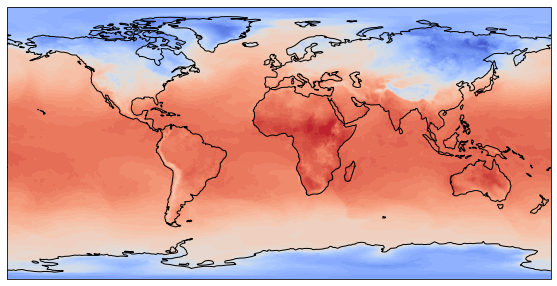

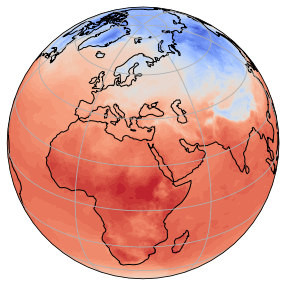

In [3]:
# Load ground truth global temperature data (on 1° resolution grid)
data = np.load("data/2m_temperature_1deg_2021_02_01.npz")
xmesh, ymesh, f = data["x"], data["y"], data["f"]

# Euclidean plot
_ = plot_field(xmesh, ymesh, f, levels=np.linspace(218, 315, 50), cmap='coolwarm', geometry='r2')
plt.savefig("figs/ground_truth_temperature_flat.png", dpi=200)

# Spherical plot
_ = plot_field(xmesh, ymesh, f, levels=np.linspace(218, 315, 50), cmap='coolwarm', geometry='s2', figsize=(5,5))
plt.savefig("figs/ground_truth_temperature_sphere.png", dpi=200)

In our experiment, we construct a toy dataset where we observe the 2m temperature at $N$ randomly sampled locations across the globe. The aim is to infer the temperature values at the $N_*$ remaining locations on the globe using a GP. The input variables $X$ are the (lat, lon)-values of the $N$ random points, which are sampled uniformly on the sphere and the target variables $y$ are the values of the 2m temperature at that location, perturbed by a small amount of noise.


In [6]:
# Generate random data to condition GP
num_data = 250

# Randomly generate points on a unit sphere
np.random.seed(78724)
randvec = np.random.randn(num_data, 3)
randvec /= np.linalg.norm(randvec, axis=1)[:, None]
_, phi_list, theta_list = cart2sph(*randvec.T)

phi_list_deg = rad2deg(phi_list)
theta_list_deg = rad2deg(theta_list)
phi_list_deg = np.rint(phi_list_deg)
theta_list_deg = np.rint(theta_list_deg)
phi_list = deg2rad(phi_list_deg)
theta_list = deg2rad(theta_list_deg)

X_train = np.stack([phi_list, theta_list], axis=-1)

# Set up query locations on a grid
lat_size = 32
lon_size = 64
lat_query = np.linspace(0, np.pi, lat_size)
lon_query = np.linspace(0, 2*np.pi, lon_size)
lon_mesh, lat_mesh = jnp.meshgrid(lon_query, lat_query)
lon_mesh_flattened = lon_mesh.flatten()
lat_mesh_flattened = lat_mesh.flatten()
X_query = np.stack([lat_mesh_flattened, lon_mesh_flattened], axis=1)

In [7]:
# Normalise temperature values
fmean = f.mean()
fstd = np.sqrt(((f - fmean)**2).mean())
f_normalised = (f - fmean)/fstd

# Extract noisy observations
noise_std = 0.1
np.random.seed(876357)
Y_train = f_normalised[phi_list_deg.astype(int), theta_list_deg.astype(int)][:,None] + noise_std*np.random.randn(num_data, 1)

## Baseline: Vanilla GP

We first conduct the experiment using a vanilla GP and see how it performs on our data. For this, we interpret the (lat, lon)-values of the inputs $X$ as points on $\mathbb{R}^2$ and do a standard GP regression using the Matérn-3/2 kernel. The GP is set up using our package `riemannianvectorgp`, which is written in JAX and can be cloned [from here](https://github.com/MJHutchinson/ExtrinsicGaugeIndependentVectorGPs).

In [8]:
# Set up Euclidean GP (we use the kernel in tensorflow-probability)
kernel_r2 = ScaledKernel(
                TFPKernel(tfp_class=tfk.MaternThreeHalves, input_dimension=2, output_dimension=1)
            ) # TFPKernel by default does not include an amplitude hyperparameter. We add this by wrapping it with ScaledKernel.
vanilla_gp = GaussianProcess(kernel_r2)

# Set GP hyperparameters
params_r2, state_r2 = set_gp_hyperparameters(next(rng), vanilla_gp, kernel_r2, lengthscale=0.6)

print(params_r2)
Kxx = kernel_r2.matrix(params_r2.kernel_params, X_train, X_train)[:,:,0,0]
print(f"log marginal likelihood: {log_marginal_likelihood(Y_train, Kxx, noise_var=noise_std**2)[0,0]}")

GaussianProcessParameters(kernel_params=ScaledKernelParams(log_amplitude=DeviceArray(-0., dtype=float32), sub_kernel_params=TFPKernelParameters(log_length_scale=DeviceArray(-0.5108256, dtype=float32, weak_type=True))))
log marginal likelihood: 190.29847717285156


In [9]:
# Condition GP on data (i.e. compute the matrix inverse)
noises = jnp.ones_like(Y_train) * noise_std**2
new_state_r2 = vanilla_gp.condition(params_r2, X_train, Y_train, noises)

In [10]:
# GP prediction
mean_r2, cov_r2 = vanilla_gp(params_r2, new_state_r2, X_query)
var_r2 = np.diag(cov_r2[:,:,0,0])

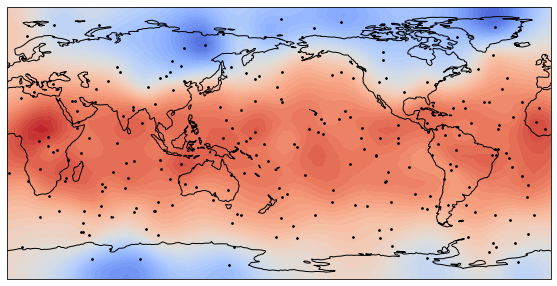

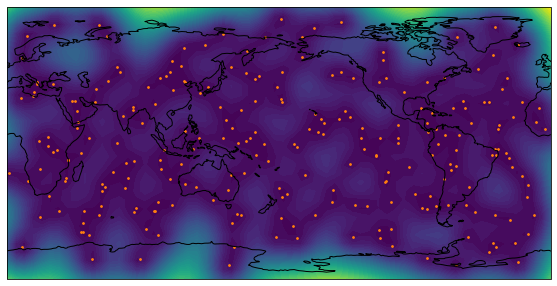

In [11]:
# Plot prediction
lon_mesh_deg = rad2deg(lon_mesh)
lat_mesh_deg = rad2deg(lat_mesh, offset=jnp.pi/2)
lon_train_deg = rad2deg(X_train[:,1])
lat_train_deg = rad2deg(X_train[:,0], offset=jnp.pi/2)

# Unnormalise mean
mean_r2_unnormalised = mean_r2*fstd + fmean
var_r2_unnormalised = var_r2*fstd**2

# Plot mean
crs = plot_field(lon_mesh_deg, lat_mesh_deg, mean_r2_unnormalised.reshape(lat_size, lon_size), levels=np.linspace(218, 315, 50), cmap='coolwarm', geometry='r2', central_longitude=180.0)
plt.scatter(lon_train_deg, lat_train_deg, c='k', s=3.0, transform=crs)
plt.savefig("figs/r2_gp_prediction_flat_longitude_180.png", dpi=200)

# Plot variance
crs = plot_field(lon_mesh_deg, lat_mesh_deg, var_r2_unnormalised.reshape(lat_size, lon_size), levels=np.linspace(0, 330, 50), cmap='viridis', geometry='r2', central_longitude=180.0)
plt.scatter(lon_train_deg, lat_train_deg, c='C1', s=3.0, transform=crs)
plt.savefig("figs/r2_gp_variance_flat_longitude_180.png", dpi=200)


Below, we plot the same results, but centered around a different axis (0°W).

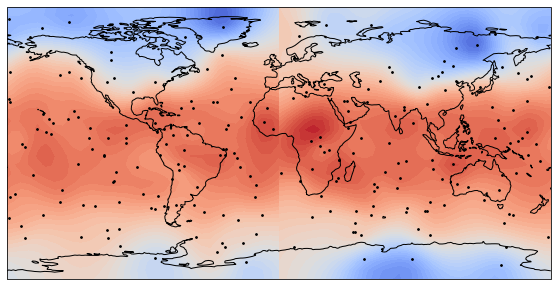

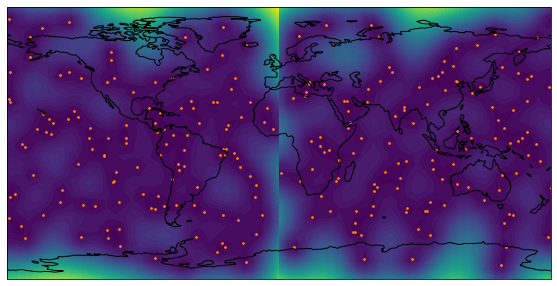

In [12]:
# Same plot, but shifted East/West by 180°
# Plot mean
crs = plot_field(lon_mesh_deg, lat_mesh_deg, mean_r2_unnormalised.reshape(lat_size, lon_size), levels=np.linspace(218, 315, 50), cmap='coolwarm', geometry='r2', central_longitude=0.0)
plt.scatter(lon_train_deg, lat_train_deg, c='k', s=3.0, transform=crs)
plt.savefig("figs/r2_gp_prediction_flat_longitude_0.png", dpi=200)

# Plot variance
crs = plot_field(lon_mesh_deg, lat_mesh_deg, var_r2_unnormalised.reshape(lat_size, lon_size), levels=np.linspace(0, 330, 50), cmap='viridis', geometry='r2', central_longitude=0.0)
plt.scatter(lon_train_deg, lat_train_deg, c='C1', s=3.0, transform=crs)
plt.savefig("figs/r2_gp_variance_flat_longitude_0.png", dpi=200)

We also plot the results on a sphere.

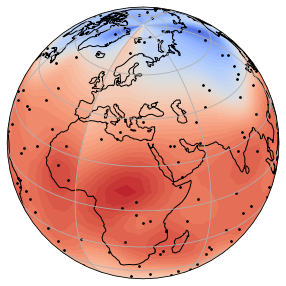

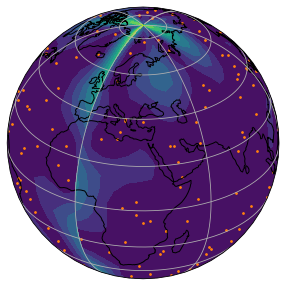

In [19]:
# Plot on sphere
# Plot mean
crs = plot_field(lon_mesh_deg, lat_mesh_deg, mean_r2_unnormalised.reshape(lat_size, lon_size), levels=np.linspace(218, 315, 50), cmap='coolwarm', geometry='s2', central_longitude=0.0, figsize=(5,5))
plt.scatter(lon_train_deg, lat_train_deg, c='k', s=3.0, transform=crs)
plt.savefig("figs/r2_gp_prediction_sphere.png", dpi=200)

# Plot variance
crs = plot_field(lon_mesh_deg, lat_mesh_deg, var_r2_unnormalised.reshape(lat_size, lon_size), levels=10, cmap='viridis', geometry='s2', central_longitude=0.0, figsize=(5,5))
plt.scatter(lon_train_deg, lat_train_deg, c='C1', s=3.0, transform=crs)
plt.savefig("figs/r2_gp_variance_sphere.png", dpi=200)

**Observations:** By using a standard GP to interpolate data points on a sphere, we observe (1) a spurious discontinuity in the mean and variance prediction at 0°W, (2) unnatural looking uncertainty regions near the poles and (3) unrealistically warm patches of land in Antarctica and the Arctic. 

Next, we see how a GP defined on the sphere can overcome these issues.

## Using a manifold GP to interpolate data points on the sphere

On the Euclidean space $\mathbb{R}^d$, a Matérn kernel is given by
\begin{align*}
k_{\nu, \rho, \sigma}(x, x') = \sigma^2 \frac{2^{1-\nu}}{\Gamma(\nu)}\left(\sqrt{2\nu} \frac{\|x - x'\|}{\rho}\right)^\nu K_\nu\left(\sqrt{2\nu} \frac{\|x - x'\|}{\rho}\right),
\end{align*}
where $\sigma^2$, $\nu$ and $\rho$ are the kernel hyperparameters and $\|x - x'\|$ is the Euclidean distance between points $x$ and $x'$. It is tempting to define an analogous kernel on a Riemannian manifold by simply replacing $\|x - x'\|$ with $d(x, x')$, the geodesic distance between $x$ and $x'$. However, as demonstrated in [Borovitskiy et al. (2021)](https://arxiv.org/pdf/2006.10160.pdf), this approach is doomed for failure as the resulting object is no longer positive definite. Instead, the 'correct' approach to defining the Matérn kernel on a Riemannian manifold is motivated by its corresponding spectral representation
\begin{align*}
k_{\nu, \rho, \sigma}(x, x') &= \sigma^2 C_{\nu, \rho, \sigma} \int \left(\frac{2\nu}{\rho^2} + \omega^2 \right)^{-\nu - \frac{d}{2}} \cos({\omega \cdot (x - x')}) \,\mathrm{d} \omega \\
&\approx \sigma^2 C_{\nu, \rho, \sigma} \sum_{n=1}^N \left(\frac{2\nu}{\rho^2} + \omega^2_n \right)^{-\nu - \frac{d}{2}} \phi_n(x) \cdot \phi_n(x'), \qquad \phi_n(x) := (\cos(\omega_n \cdot x), \, \sin(\omega_n \cdot x))
\end{align*}
where $C_{\nu, \rho, \sigma} > 0$ is a constant that depends on the hyperparameters. The analogous expression on a compact Riemannian manifold $(Q, g)$ is given by
\begin{align*}
k_{\nu, \rho, \sigma}^{Q}(x, x') \approx \sigma^2 C_{\nu, \rho, \sigma} \sum_{n=1}^N \left(\frac{2\nu}{\rho^2} + \lambda_n \right)^{-\nu - \frac{d}{2}} \phi_n(x) \phi_n(x'),
\end{align*}
where $\phi_n$ and $\lambda_n$ are the eigenfunctions and eigenvalues respectively of the negative Laplace-Beltrami operator $-\Delta_g$ (see the Appendix for the derivation).

On the sphere, the eigenvalues of the Laplace-Beltrami operator are given by $\lambda_n = n(n+1)$ and the eigenfunctions $\phi_n$ are the spherical harmonics of degree $n$.

In [14]:
# Set up manifold GP
S2 = EmbeddedS2(1.0) # Sphere of unit radius

kernel_s2 = ScaledKernel(
            MaternCompactRiemannianManifoldKernel(smoothness=3/2, 
                                                  compact_riemannian_manifold=S2,
                                                  truncation=144 # This is the number of eigenfunctions used to approximate the kernel. We have only implemented 144.
                                                  )
            )
manifold_gp = GaussianProcess(kernel_s2)

# Set GP hyperparameters
params_s2, state_s2 = set_gp_hyperparameters(next(rng), manifold_gp, kernel_s2, lengthscale=0.6)

print(params_s2)
Kxx = kernel_s2.matrix(params_s2.kernel_params, X_train, X_train)[:,:,0,0]
print(f"log marginal likelihood: {log_marginal_likelihood(Y_train, Kxx, noise_var=noise_std**2)[0,0]}")

GaussianProcessParameters(kernel_params=ScaledKernelParams(log_amplitude=DeviceArray(4.334126, dtype=float32), sub_kernel_params=SquaredExponentialCompactRiemannianManifoldKernelParams(log_length_scale=DeviceArray(-0.5108256, dtype=float32, weak_type=True))))
log marginal likelihood: 156.86691284179688


Conditioning and predicting using the manifold GP is done in the same way as in the Euclidean case.

In [15]:
# Condition GP on data
new_state_s2 = manifold_gp.condition(params_s2, X_train, Y_train, noises)

In [16]:
# GP prediction
mean_s2, cov_s2 = manifold_gp(params_s2, new_state_s2, X_query)
var_s2 = np.diag(cov_s2[:,:,0,0])

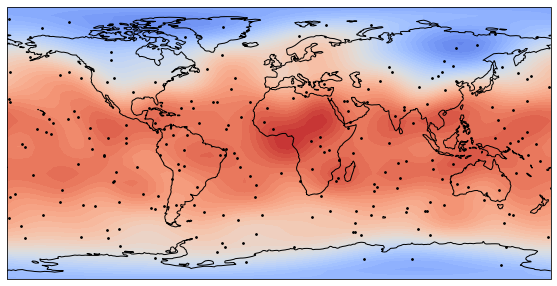

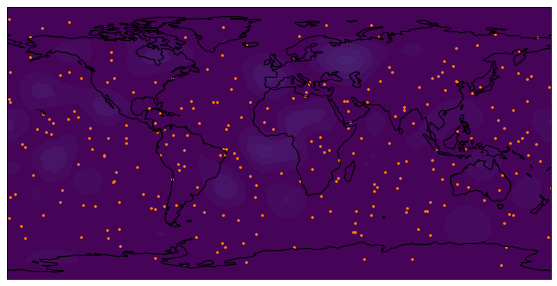

In [17]:
# Plot prediction
lon_mesh_deg = rad2deg(lon_mesh)
lat_mesh_deg = rad2deg(lat_mesh, offset=jnp.pi/2)
lon_train_deg = rad2deg(X_train[:,1])
lat_train_deg = rad2deg(X_train[:,0], offset=jnp.pi/2)

# Unnormalise mean
mean_s2_unnormalised = mean_s2*fstd + fmean
var_s2_unnormalised = var_s2*fstd**2

# Plot mean
crs = plot_field(lon_mesh_deg, lat_mesh_deg, mean_s2_unnormalised.reshape(lat_size, lon_size), levels=np.linspace(218, 315, 50), cmap='coolwarm', geometry='r2')
plt.scatter(lon_train_deg, lat_train_deg, c='k', s=3.0, transform=crs)
plt.savefig("figs/s2_gp_prediction_flat_longitude_0.png", dpi=200)

# Plot variance
crs = plot_field(lon_mesh_deg, lat_mesh_deg, var_s2_unnormalised.reshape(lat_size, lon_size), levels=np.linspace(0, 330, 50), cmap='viridis', geometry='r2')
plt.scatter(lon_train_deg, lat_train_deg, c='C1', s=3.0, transform=crs)
plt.savefig("figs/s2_gp_variance_flat_longitude_0.png", dpi=200)


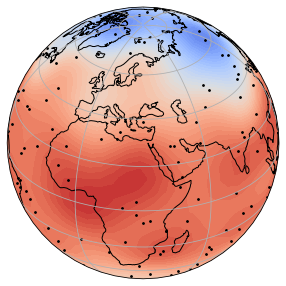

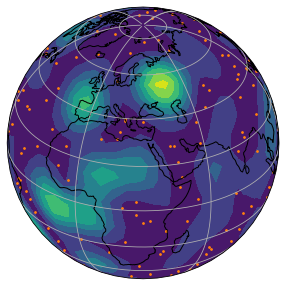

In [20]:
# Spherical plot
# Plot mean
crs = plot_field(lon_mesh_deg, lat_mesh_deg, mean_s2_unnormalised.reshape(lat_size, lon_size), levels=np.linspace(218, 315, 50), cmap='coolwarm', geometry='s2', figsize=(5,5))
plt.scatter(lon_train_deg, lat_train_deg, c='k', s=3.0, transform=crs)
plt.savefig("figs/s2_gp_prediction_sphere_longitude_0.png", dpi=200)

# Plot variance
crs = plot_field(lon_mesh_deg, lat_mesh_deg, var_s2_unnormalised.reshape(lat_size, lon_size), levels=None, cmap='viridis', geometry='s2', figsize=(5,5))
plt.scatter(lon_train_deg, lat_train_deg, c='C1', s=3.0, transform=crs)
plt.savefig("figs/s2_gp_variance_sphere_longitude_0.png", dpi=200)

The results from the manifold GP are much better - we have predictions that are closer to the truth with uncertainty regions that are consistent with the observations.

## Create animation

In [ ]:
from celluloid import Camera

## Appendix

In this appendix, we look at the mathematical theory behind the method used in this notebook. This is discussed more rigorously in [Borovitskiy et al. (2021)](https://arxiv.org/pdf/2006.10160.pdf).

### The stochastic partial differential equations (SPDE) view of Matérn Gaussian processes in $\mathbb{R}^d$
Matérn GPs are a class of GPs with kernels of the form
\begin{align*}
k_{\nu, \rho, \sigma}(x, x') = \sigma^2 \frac{2^{1-\nu}}{\Gamma(\nu)}\left(\sqrt{2\nu} \frac{\|x - x'\|}{\rho}\right)^\nu K_\nu\left(\sqrt{2\nu} \frac{\|x - x'\|}{\rho}\right),
\end{align*}
where $\sigma^2$, $\nu$ and $\rho$ are the variance, smoothness and lengthscale hyperparameters respectively, $K_\nu$ is the modified Bessel function of the second kind and $\Gamma$ is the Gamma function.
It appears mysterious why a kernel of such complicated form is ever being used, yet it remains to be one of the more popular kernels used in geostatistics and other areas of science.

The answer to this partially lies in how it arises as a solution to a particular SPDE of the form
\begin{align*}
\left(\frac{2\nu}{\rho^2} - \Delta\right)^{\frac{\nu}{2} + \frac{d}{4}} f = \mathcal{W},
\end{align*}
where $d$ is the physical dimension of the input space, $\Delta$ is the Laplacian operator and $\mathcal{W}$ is the Gaussian white noise process. Below, we give an idea of how to make sense of this equation, in particular, how to define the operator $\left(\frac{2\nu}{\rho^2} - \Delta\right)^{\frac{\nu}{2} + \frac{d}{4}}$ and how to define the process $\mathcal{W}$.

### Functional calculus and pseudo-differential operators
To avoid technicalities, we work on a compact domain $\Omega \subset \mathbb{R}^d$ and impose a Dirichlet boundary condition $f(x) = 0$ for $x \in \partial \Omega$ on the SPDE above.
We start by defining the eigenvalues and eigenfunctions of the negative Laplace operator $-\Delta$ as tuples $(\lambda_i, \phi_i)$, $i = \mathcal{I}$ that satisfy
\begin{align*}
-\Delta \phi_i(x) &= \lambda_i \phi_i(x), \quad \forall x \in \Omega, \quad \forall i \in \mathcal{I}, \\
\phi_i(x) &= 0, \quad \forall x \in \partial \Omega.
\end{align*}
where $\mathcal{I}$ is an index set. It is well-known that if $\Omega$ is compact, then the index set is countable, so we set $\mathcal{I} = \mathbb{Z}$ (this is not true when $\Omega$ is the whole $\mathbb{R}^d$, which is the root cause of the technicalities involved in the $\mathbb{R}^d$ setting).
Moreover, the eigenfunctions $(\phi_i)_{i \in \mathcal{I}}$ are orthonormal with respect to the $L^2$-inner product $\left<\phi_i, \phi_j\right>_{L^2} = \delta_{ij}$ and form a (Schauder) basis of the Hilbert space $L^2(\Omega)$. Thus for any $f \in L^2(\Omega)$, we have
\begin{align*}
f(x) = \sum_{i=1}^\infty a_i \phi_i(x), \quad a_i = \left<f, \phi_i\right>_{L^2},
\end{align*}
and moreover, assuming that it is twice differentiable,
\begin{align*}
-\Delta f(x) &= \sum_{i=1}^\infty a_i (-\Delta \phi_i(x)), \quad a_i = \left<f, \phi_i\right>_{L^2}, \\
&= \sum_{i=1}^\infty \lambda_i \left<f, \phi_i\right>_{L^2} \phi_i(x).
\end{align*}

In general, given a function $\Phi : \mathbb{R}^+ \rightarrow \mathbb{R}$ (called the *symbol*), we can define a new operator $\Phi(-\Delta)$ by replacing $\lambda_i$ in the above expression with $\Phi(\lambda_i)$, an idea known as *functional calculus* and the resulting operator known as a *pseudo-differential operator*. Thus, for a symbol $\Phi(x) = (\frac{2\nu}{\rho^2} + x)^{\frac{\nu}{2} + \frac{d}{4}}$, we have
\begin{align*}
\left(\frac{2\nu}{\rho^2} - \Delta\right)^{\frac{\nu}{2} + \frac{d}{4}} f := \sum_{i=1}^\infty \left(\frac{2\nu}{\rho^2} + \lambda_i\right)^{\frac{\nu}{2} + \frac{d}{4}} \left<f, \phi_i\right>_{L^2} \phi_i(x),
\end{align*}
which defines the operator in question.

### Generalised Gaussian random fields on $L^2(\Omega)$
Formally speaking, the white noise process $\mathcal{W}(x)$ is a Gaussian process with zero mean and kernel $k(x, x') = \delta (x - x')$. Note however that the latter is not a kernel in the usual sense as $\delta (x - x')$ is a distribution and therefore does not make sense pointwise. To make proper sense of this, we introduce the notion of a *generalised Gaussian random field* on $L^2(\Omega)$ with mean $m \in L^2(\Omega)^*$ and covariance operator $\mathcal{K} : L^2(\Omega) \rightarrow L^2(\Omega)^*$, which is a random field $f : \Omega \rightarrow L^2(\Omega)^*$ satisfying:

1. $\mathbb{E}[\left<f, h\right>_{L^2}] = \left<m, h\right>_{L^2}$, for any $h \in L^2(\Omega)$, and
2. $\mathrm{Cov}[\left<f, h\right>_{L^2}, \left<f, g\right>_{L^2}] = \left<\mathcal{K} h, g\right>_{L^2}$, for any $g, h \in L^2(\Omega)$.

We define the Gaussian white noise process $\mathcal{W}(x)$ properly as a generalised Gaussian random field on $L^2(\Omega)$ with zero mean and covariance operator $\mathcal{K} = id$.

It is useful to observe that the above notion is indeed a generalised notion of a Gaussian random field by noting the following. Let $f \in L^2(\Omega)$ be a GP in the usual sense with mean $m(x)$ and kernel $k(x, x')$. Then for any $h \in L^2(\Omega)$, we have
\begin{align*}
\mathbb{E}[\left<f, h\right>_{L^2}] = \mathbb{E}\left[\int f(x) h(x) \mathrm{d} x\right] = \int \mathbb{E}[f(x)] h(x) \mathrm{d} x = \int m(x) h(x) \mathrm{d} x = \left<m, h\right>_{L^2},
\end{align*}
which satisfies property (1) and for any $g, h \in L^2(\Omega)$, we have
\begin{align*}
\mathrm{Cov}[\left<f, h\right>_{L^2}, \left<f, g\right>_{L^2}] &= \mathrm{Cov}\left[\left(\int f(x) h(x) \mathrm{d} x\right), \left(\int f(x') g(x') \mathrm{d} x'\right)\right] \\
&= \iint h(x) \, \mathrm{Cov}[f(x), f(x')] \, g(x') \mathrm{d} x \mathrm{d} x' \\
&= \iint h(x) \, k(x, x') \, g(x') \mathrm{d} x \mathrm{d} x' \\
&= \left<\mathcal{K} h, g\right>_{L^2},
\end{align*}
where
\begin{align*}
\mathcal{K} h(x') := \int k(x, x') h(x) \mathrm{d}x,
\end{align*}
hence satisfying property (2) for the covariance.

### Combining the ideas above to compute the kernel for Matérn GPs
For simplity, we denote by $\mathcal{L}$ the pseudo-differential operator
\begin{align*}
\mathcal{L} f := \left(\frac{2\nu}{\rho^2} - \Delta\right)^{\frac{\nu}{2} + \frac{d}{4}} f,
\end{align*}
and the corresponding symbol by $\Phi(\cdot)$.
One can show that the operator $\mathcal{L}$ is (i) self-adjoint in $L^2$, that is, $\left<\mathcal{L} f, h\right>_{L^2} = \left<f, \mathcal{L} h\right>_{L^2}$ and (ii) invertible, where the inverse operator is given by $\mathcal{L}^{-1} = \Phi(-\Delta)^{-1}$. Thus, from the SPDE $\mathcal{L} f = \mathcal{W}$, we have for any $h \in L^2(\Omega)$,
\begin{align*}
\mathbb{E}[\left<f, h\right>_{L^2}] &= \mathbb{E}[\left<\mathcal{L}^{-1} \mathcal{W}, h\right>_{L^2}] = \mathbb{E}[\left<\mathcal{W}, \mathcal{L}^{-1} h\right>_{L^2}] = 0,
\end{align*}
where we used the self-adjointness of $\mathcal{L}$ and therefore also of $\mathcal{L}^{-1}$ in the third line, and the zero-mean property of $\mathcal{W}$ in the last line. Moreover, for any $g, h \in L^2(\Omega)$, we have
\begin{align*}
\mathrm{Cov}[\left<f, h\right>_{L^2}, \left<f, g\right>_{L^2}] &= \mathbb{E}[\left<\mathcal{L}^{-1} \mathcal{W}, h\right>_{L^2}, \left<\mathcal{L}^{-1} \mathcal{W}, g\right>_{L^2}] \\
&= \mathbb{E}[\left<\mathcal{W}, \mathcal{L}^{-1} h\right>_{L^2}, \left<\mathcal{W}, \mathcal{L}^{-1} g\right>_{L^2}] \\
&= \left<\mathcal{L}^{-1} h, \mathcal{L}^{-1} g\right>_{L^2},
\end{align*}
where we used that the covariance operator of $\mathcal{W}$ is the identity operator. Now, noting from the previous section that
\begin{align*}
\mathcal{L}^{-1} h := \sum_{i=1}^\infty \Phi(\lambda_i)^{-1} \left<h, \phi_i\right>_{L^2} \phi_i(x),
\end{align*}
we get
\begin{align*}
\left<\mathcal{L}^{-1} h, \mathcal{L}^{-1} g\right>_{L^2} &= \int \left(\sum_{i=1}^\infty \Phi(\lambda_i)^{-1} \left<h, \phi_i\right>_{L^2} \phi_i(x)\right)\left(\sum_{j=1}^\infty \Phi(\lambda_j)^{-1} \left<g, \phi_j\right>_{L^2} \phi_j(x)\right) \mathrm{d} x \\
&= \sum_{i=1}^\infty \sum_{j=1}^\infty \Phi(\lambda_i)^{-1} \Phi(\lambda_j)^{-1} \left<h, \phi_i\right>_{L^2} \left<g, \phi_j\right>_{L^2} \underbrace{\left<\phi_i, \phi_j\right>_{L^2}}_{= \delta_{ij}} \\
&= \sum_{i=1}^\infty \Phi(\lambda_i)^{-2} \left<h, \phi_i\right>_{L^2} \left<g, \phi_i\right>_{L^2} \\
&= \sum_{i=1}^\infty \Phi(\lambda_i)^{-2} \left(\int h(x) \phi_i(x) \mathrm{d} x\right) \left(\int g(x') \phi_i(x') \mathrm{d} x'\right) \\
&= \left<\mathcal{K} h, g\right>_{L^2},
\end{align*}
where
\begin{align*}
\mathcal{K} h(x') := \int h(x) \underbrace{\sum_{i=1}^\infty \Phi(\lambda_i)^{-2} \phi_i(x) \phi_i(x')}_{=: k(x, x')} \mathrm{d} x.
\end{align*}

So the solution $f$ to the SPDE $\mathcal{L} f = \mathcal{W}$ is a Gaussian process with zero mean and kernel

\begin{align*}
k(x, x') = \sum_{i=1}^\infty \Phi(\lambda_i)^{-2} \phi_i(x) \phi_i(x') = \sum_{i=1}^\infty \left(\frac{2\nu}{\rho^2} + \lambda_i \right)^{-\nu - \frac{d}{2}} \phi_i(x) \phi_i(x').
\end{align*}
While we have only demonstrated this in the case of bounded domains, the same technique holds in the unbounded cases, albeit with some technicalities. One can indeed show that the above expression for the kernel, where we replace the sum by an integral over $i \in \mathcal{I}$ (now an uncountable index set), is equivalent to the expression shown at the beginning of the appendix.

In [Borovitskiy et al. (2021)](https://arxiv.org/pdf/2006.10160.pdf), it is further proven that the Matérn GP $f$ is equivalent to the zero-mean Gaussian white noise process defined on the Sobolev space $H^{\nu + \frac{d}{2}}$ (instead of $L^2$), thus making it a very natural stochastic process despite the scary appearance.

### Extension to compact Riemannian manifolds
The main idea in [Borovitskiy et al. (2021)](https://arxiv.org/pdf/2006.10160.pdf) is that all of the above construction holds on a compact Riemannian manifold $(Q, g)$ by replacing the Laplacian $\Delta$ by the Laplace-Beltrami operator $\Delta_g$, which bypasses the typical construction of Matérn GPs using Bochner's theorem, which does not exist on a general Riemannian manifold. On the sphere, the eigenfunctions of the Laplace-Beltrami operator correspond to the spherical harmonics, which recovers the algorithm considered in this notebook.

